<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/saliency%20heat%20map%20resnet%2018%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

heat map o saliency map resnet18

https://debuggercafe.com/basic-introduction-to-class-activation-maps-in-deep-learning-using-pytorch/

## [Basic Introduction to Class Activation Maps in Deep Learning using PyTorch](https://debuggercafe.com/basic-introduction-to-class-activation-maps-in-deep-learning-using-pytorch/)
![](https://debuggercafe.com/wp-content/uploads/2021/05/Basic-Introduction-to-Class-Activation-Maps-in-Deep-Learning-using-PyTorch-e1621422394452.jpg)

## Download the Prepare the Data

In [ ]:
import requests
url = "https://drive.google.com/uc?id=1gtP1McQNNnNkQl9d4cz8aiUsnCkXWOI3&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
   f.write(r.content)

In [ ]:
!unzip input.zip

Archive:  input.zip
   creating: input/
  inflating: input/image_2.jpg       
  inflating: input/image_1.jpg       


In [ ]:
import requests
url = "https://drive.google.com/uc?id=1GxuLED7FGsfa5VtI_DCWnwyP0TDrTwFe&export=download"
r = requests.get(url)
with open('LOC_synset_mapping.txt', 'wb') as f:
   f.write(r.content)

In [ ]:
!mkdir outputs

## Class Activation Map Code

In [ ]:
%%writefile cam.py
import numpy as np
import cv2
import argparse

from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image',
                    default='input/image_1.jpg')
args = vars(parser.parse_args())

# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def show_cam(CAMs, width, height, orig_image, class_idx, all_classes, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.5
        # put class label text on the result
        cv2.putText(result, all_classes[class_idx[i]], (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        # cv2.imshow('CAM', result/255.)
        # cv2.waitKey(0)
        cv2.imwrite(f"outputs/CAM_{save_name}.jpg", result)

def load_synset_classes(file_path):
    # load the synset text file for labels
    all_classes = []
    with open(file_path, 'r') as f:
        all_lines = f.readlines()
        labels = [line.split('\n') for line in all_lines]
        for label_list in labels:
            current_class = [name.split(',') for name in label_list][0][0][10:]
            all_classes.append(current_class)
    return all_classes

# get all the classes in a list
all_classes = load_synset_classes('LOC_synset_mapping.txt')

# read and visualize the image
image = cv2.imread(args['input'])
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

# load the model
model = models.resnet18(pretrained=True).eval()
# hook the feature extractor
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

# define the transforms, resize => tensor => normalize
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

# apply the image transforms
image_tensor = transforms(image)
# add batch dimension
image_tensor = image_tensor.unsqueeze(0)
# forward pass through model
outputs = model(image_tensor)
# get the softmax probabilities
probs = F.softmax(outputs).data.squeeze()
# get the class indices of top k probabilities
class_idx = topk(probs, 1)[1].int()

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
# file name to save the resulting CAM image with
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
# show and save the results
show_cam(CAMs, width, height, orig_image, class_idx, all_classes, save_name)

Overwriting cam.py


In [ ]:
!python cam.py --input input/image_1.jpg

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100% 44.7M/44.7M [00:03<00:00, 11.9MB/s]
cam.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [ ]:
!python cam.py --input input/image_2.jpg

cam.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


## Visualize the Results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 15, 12

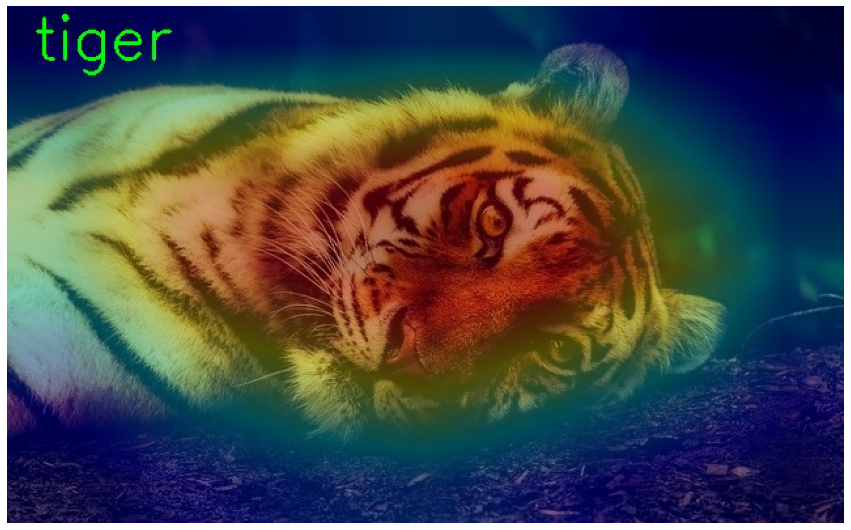

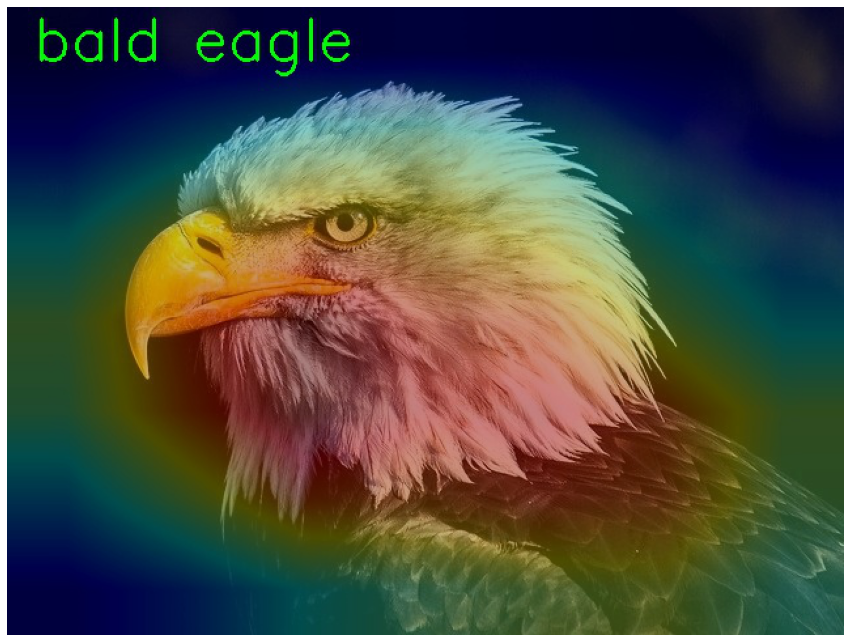

In [ ]:
image_1 = plt.imread('outputs/CAM_image_1.jpg')
plt.imshow(image_1)
plt.axis('off')
plt.show()

image_2 = plt.imread('outputs/CAM_image_2.jpg')
plt.imshow(image_2)
plt.axis('off')
plt.show()

## Download the Outputs

In [ ]:
!zip -r /content/outputs outputs

updating: outputs/ (stored 0%)
  adding: outputs/CAM_image_2.jpg (deflated 1%)
  adding: outputs/CAM_image_1.jpg (deflated 0%)


In [ ]:
from google.colab import files

files.download('outputs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>